In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn tqdm openai sentence-transformers pyreadr

In [ ]:
import json
import re
from tqdm import tqdm


In [ ]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001-d65fd66f4e35682a.parquet', 'validation': 'data/validation-00000-of-00001-c657d4b47c29b03d.parquet', 'test': 'data/test-00000-of-00001-3da28211228c2ec3.parquet'}
df = pd.read_parquet("hf://datasets/threite/Bundestag-v2/" + splits["train"])

print(df.shape)

df.head()

df.info()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(143406, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143406 entries, 0 to 143405
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    143406 non-null  object
 1   party   143406 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [ ]:
parties = ["CDU/CSU", "SPD", "GRUENE", "FDP", "PDS/LINKE"]
df = df[df["party"].isin(parties)]

df = df.sample(n=1000, random_state=42)

import re

4

In [ ]:
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)

5

In [ ]:
def extract_json(text):
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if match:
        return json.loads(match.group())
    else:
        raise ValueError("No JSON found in model output")


6

In [ ]:
def classify_ideology(speech_text):
    prompt = f"""
You are a political scientist specializing in German party politics.

Analyze the following Bundestag speech.

Ideologies:
- Conservative
- Liberal
- Social Democratic
- Green
- Left-wing Socialist
- Nationalist / Right-wing Populist

Instructions:
1. Assign probabilities to each ideology (sum = 1).
2. Identify 2–3 dominant political themes.
3. Provide a brief justification.

Return JSON ONLY:
{{
  "ideology_scores": {{
    "Conservative": 0.0,
    "Liberal": 0.0,
    "Social Democratic": 0.0,
    "Green": 0.0,
    "Left-wing Socialist": 0.0,
    "Nationalist / Right-wing Populist": 0.0
  }},
  "dominant_themes": [],
  "justification": ""
}}

Speech:
\"\"\"
{speech_text}
\"\"\"
"""

    response = client.chat.completions.create(
        model="arcee-ai/trinity-large-preview:free",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )

    raw = response.choices[0].message.content

    if raw is None or raw.strip() == "":
        raise ValueError("Empty response")

    try:
        return json.loads(raw)
    except json.JSONDecodeError:
        return extract_json(raw)


In [ ]:
from openai import OpenAI
import os

client = OpenAI(
    api_key = "API_KEY",
    base_url="https://openrouter.ai/api/v1",
)

In [ ]:
results = []

for text in tqdm(df["clean_text"]):
    try:
        results.append(classify_ideology(text))
    except Exception as e:
        print("Skipping:", e)
        results.append(None)


  2%|▏         | 21/1000 [01:42<1:24:30,  5.18s/it]

Skipping: Expecting ',' delimiter: line 4 column 17 (char 66)


100%|██████████| 1000/1000 [1:24:36<00:00,  5.08s/it]


In [ ]:
clean_results = [r for r in results if r is not None]
clean_df = df.iloc[:len(clean_results)].copy()


In [ ]:
ideology_df = pd.json_normalize(
    [r["ideology_scores"] for r in clean_results]
)

clean_df = pd.concat(
    [clean_df.reset_index(drop=True), ideology_df.reset_index(drop=True)],
    axis=1
)


In [ ]:
party_profiles = (
    clean_df
    .groupby("party")[ideology_df.columns]
    .mean()
)


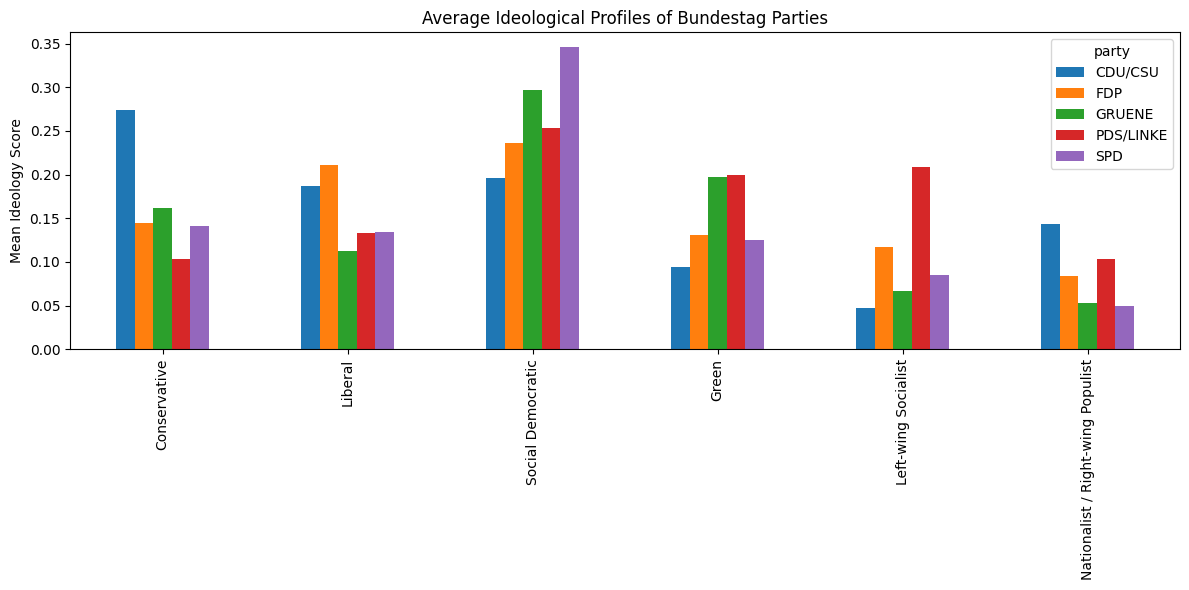

In [ ]:
import matplotlib.pyplot as plt

party_profiles.T.plot(kind="bar", figsize=(12,6))
plt.title("Average Ideological Profiles of Bundestag Parties")
plt.ylabel("Mean Ideology Score")
plt.tight_layout()
plt.show()

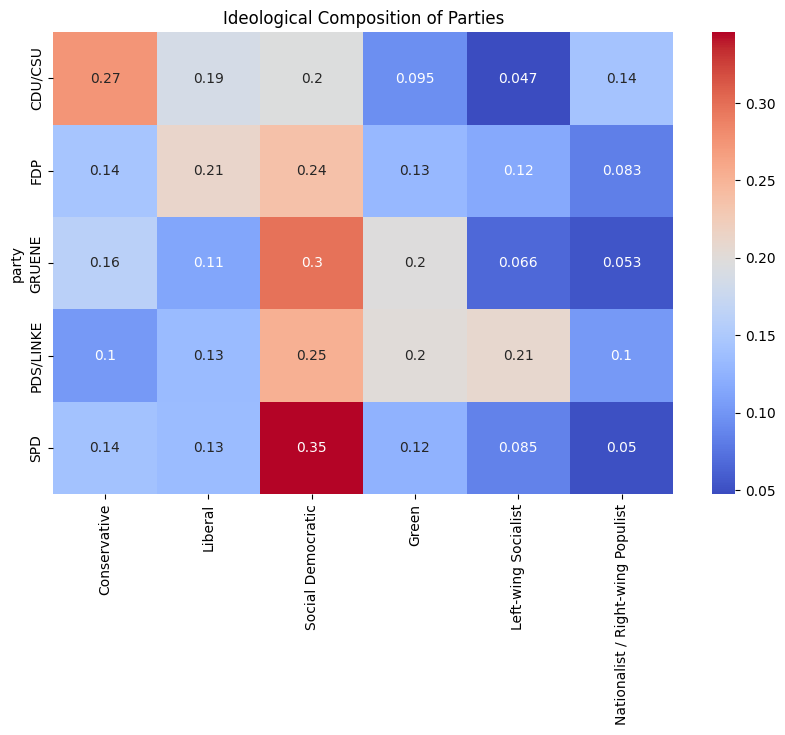

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(party_profiles, annot=True, cmap="coolwarm")
plt.title("Ideological Composition of Parties")
plt.show()


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(df["clean_text"].tolist())

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
df["embedding"] = list(embeddings)

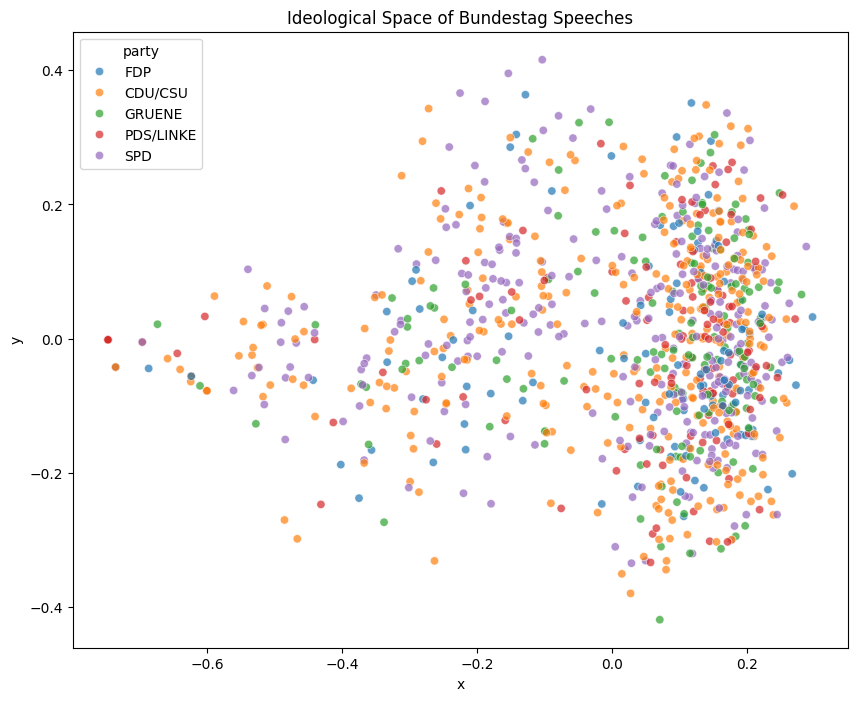

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

X = np.vstack(df["embedding"].values)
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

df["x"] = coords[:,0]
df["y"] = coords[:,1]

plt.figure(figsize=(10,8))
sns.scatterplot(
    data=df,
    x="x", y="y",
    hue="party",
    alpha=0.7
)
plt.title("Ideological Space of Bundestag Speeches")
plt.show()


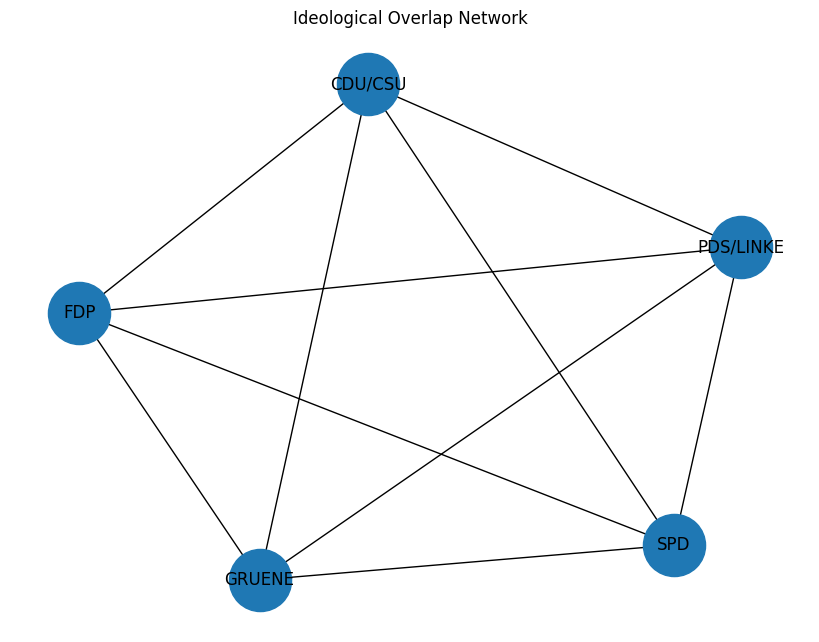

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(party_profiles)
sim_df = pd.DataFrame(sim_matrix, index=party_profiles.index, columns=party_profiles.index)

G = nx.Graph()

for p in parties:
    G.add_node(p)

for i,p1 in enumerate(parties):
    for j,p2 in enumerate(parties):
        if i < j:
            sim = sim_df.loc[p1,p2]
            if sim > 0.7:
                G.add_edge(p1, p2, weight=sim)

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000)
plt.title("Ideological Overlap Network")
plt.show()

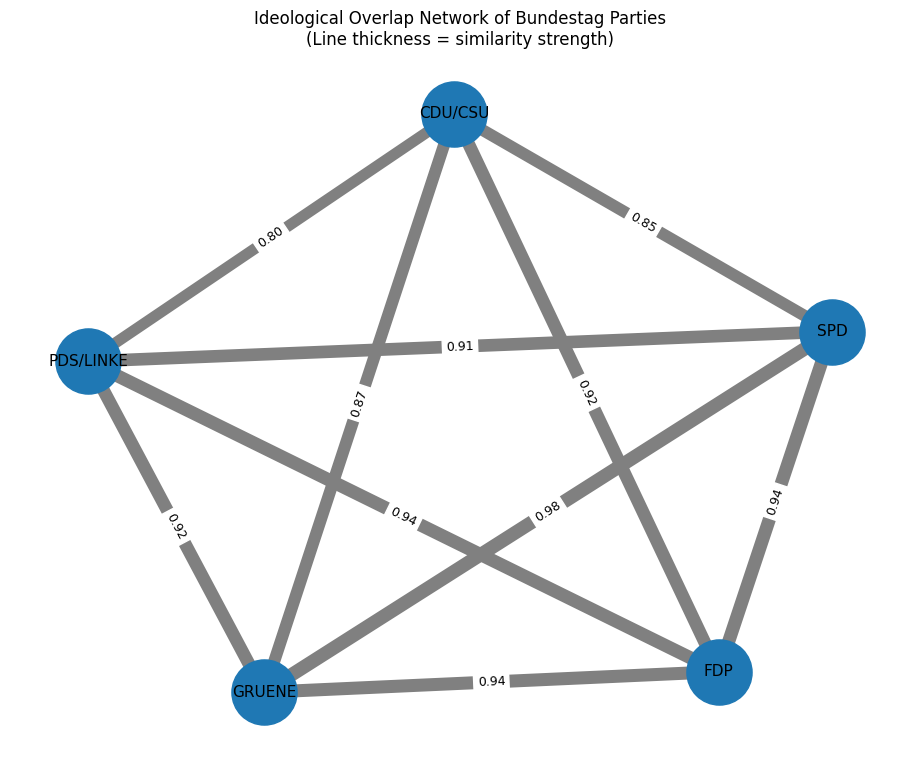

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

threshold = 0.6

G = nx.Graph()

parties = sim_df.index.tolist()

for p in parties:
    G.add_node(p)

for i, p1 in enumerate(parties):
    for j, p2 in enumerate(parties):
        if i < j:
            sim = sim_df.loc[p1, p2]
            if sim > threshold:
                G.add_edge(p1, p2, weight=sim)

pos = nx.spring_layout(G, seed=42, k=0.8)

weights = [G[u][v]['weight'] for u, v in G.edges()]

edge_widths = [w * 10 for w in weights]

plt.figure(figsize=(9,7))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2200,
    font_size=11,
    width=edge_widths,
    edge_color="gray"
)

plt.title("Ideological Overlap Network of Bundestag Parties\n(Line thickness = similarity strength)")
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
plt.show()


In [2]:
from google.colab import files
uploaded = files.upload()


Saving PROJECT_V5.ipynb to PROJECT_V5.ipynb


In [3]:
import json

nb_path = "PROJECT_V5.ipynb"

with open(nb_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

if "widgets" in nb.get("metadata", {}):
    del nb["metadata"]["widgets"]

with open(nb_path, "w", encoding="utf-8") as f:
    json.dump(nb, f, indent=1)

print("Widget metadata removed!")


Widget metadata removed!
